# 4. Sensors Objects and Localization

From HW 6, we used Gradient Descent to solve the problem of figuring out where
objects are given noisy distance measurements - taking code from HW 6

In [9]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.spatial
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Gradient descent optimization
# The learning rate is specified by eta
class GDOptimizer(object):
    def __init__(self, eta):
        self.eta = eta

    def initialize(self, layers):
        pass

    # This function performs one gradient descent step
    # layers is a list of dense layers in the network
    # g is a list of gradients going into each layer before the nonlinear activation
    # a is a list of of the activations of each node in the previous layer going 
    def update(self, layers, g, a):
        m = a[0].shape[1]
        for layer, curGrad, curA in zip(layers, g, a):
            update = np.dot(curGrad,curA.T)
            updateB = np.sum(curGrad,1).reshape(layer.b.shape)
            layer.updateWeights(-self.eta/m * np.dot(curGrad,curA.T))
            layer.updateBias(-self.eta/m * np.sum(curGrad,1).reshape(layer.b.shape))

# Cost function used to compute prediction errors
class QuadraticCost(object):

    # Compute the squared error between the prediction yp and the observation y
    # This method should compute the cost per element such that the output is the
    # same shape as y and yp
    @staticmethod
    def fx(y,yp):
        return 0.5 * np.square(yp-y)

    # Derivative of the cost function with respect to yp
    @staticmethod
    def dx(y,yp):
        return y - yp

# Sigmoid function fully implemented as an example
class SigmoidActivation(object):
    @staticmethod
    def fx(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def dx(z):
        return SigmoidActivation.fx(z) * (1 - SigmoidActivation.fx(z))
        
# Hyperbolic tangent function
class TanhActivation(object):

    # Compute tanh for each element in the input z
    @staticmethod
    def fx(z):
        return np.tanh(z)

    # Compute the derivative of the tanh function with respect to z
    @staticmethod
    def dx(z):
        return 1 - np.square(np.tanh(z))

# Rectified linear unit
class ReLUActivation(object):
    @staticmethod
    def fx(z):
        return np.maximum(0,z)

    @staticmethod
    def dx(z):
        return (z>0).astype('float')

# Linear activation
class LinearActivation(object):
    @staticmethod
    def fx(z):
        return z

    @staticmethod
    def dx(z):
        return np.ones(z.shape)

# This class represents a single hidden or output layer in the neural network
class DenseLayer(object):

    # numNodes: number of hidden units in the layer
    # activation: the activation function to use in this layer
    def __init__(self, numNodes, activation):
        self.numNodes = numNodes
        self.activation = activation

    def getNumNodes(self):
        return self.numNodes

    # Initialize the weight matrix of this layer based on the size of the matrix W
    def initialize(self, fanIn, scale=1.0):
        s = scale * np.sqrt(6.0 / (self.numNodes + fanIn))
        self.W = np.random.normal(0, s,
                                   (self.numNodes,fanIn))
        #self.b = np.zeros((self.numNodes,1))
        self.b = np.random.uniform(-1,1,(self.numNodes,1))

    # Apply the activation function of the layer on the input z
    def a(self, z):
        return self.activation.fx(z)

    # Compute the linear part of the layer
    # The input a is an n x k matrix where n is the number of samples
    # and k is the dimension of the previous layer (or the input to the network)
    def z(self, a): 
        #print('a:\n'+str(a))
        #print('Wa:\n'+str(self.W.dot(a)))
        return self.W.dot(a) + self.b # Note, this is implemented where we assume a is k x n

    # Compute the derivative of the layer's activation function with respect to z
    # where z is the output of the above function.
    # This derivative does not contain the derivative of the matrix multiplication
    # in the layer.  That part is computed below in the model class.
    def dx(self, z):
        return self.activation.dx(z)

    # Update the weights of the layer by adding dW to the weights
    def updateWeights(self, dW):
        self.W = self.W + dW

    # Update the bias of the layer by adding db to the bias
    def updateBias(self, db):
        self.b = self.b + db

# This class handles stacking layers together to form the completed neural network
class Model(object):

    # inputSize: the dimension of the inputs that go into the network
    def __init__(self, inputSize):
        self.layers = []
        self.inputSize = inputSize

    # Add a layer to the end of the network
    def addLayer(self, layer):
        self.layers.append(layer)

    # Get the output size of the layer at the given index
    def getLayerSize(self, index):
        if index >= len(self.layers):
            return self.layers[-1].getNumNodes()
        elif index < 0:
            return self.inputSize
        else:
            return self.layers[index].getNumNodes()

    # Initialize the weights of all of the layers in the network and set the cost
    # function to use for optimization
    def initialize(self, cost, initializeLayers=True):
        self.cost = cost
        if initializeLayers:
            for i in range(0,len(self.layers)):
                if i == len(self.layers) - 1:
                    self.layers[i].initialize(self.getLayerSize(i-1))
                else:
                    self.layers[i].initialize(self.getLayerSize(i-1))

    # Compute the output of the network given some input a
    # The matrix a has shape n x k where n is the number of samples and
    # k is the dimension
    # This function returns
    # yp - the output of the network
    # a - a list of inputs for each layer of the newtork where
    #     a[i] is the input to layer i
    # z - a list of values for each layer after evaluating layer.z(a) but
    #     before evaluating the nonlinear function for the layer
    def evaluate(self, x):
        curA = x.T
        a = [curA]
        z = []
        for layer in self.layers:
            z.append(layer.z(curA))
            curA = layer.a(z[-1])
            a.append(curA)
        yp = a.pop()
        return yp, a, z

    # Compute the output of the network given some input a
    # The matrix a has shape n x k where n is the number of samples and
    # k is the dimension
    def predict(self, a):
        a,_,_ = self.evaluate(a)
        return a.T

    # Train the network given the inputs x and the corresponding observations y
    # The network should be trained for numEpochs iterations using the supplied
    # optimizer
    def train(self, x, y, numEpochs, optimizer):

        # Initialize some stuff
        n = x.shape[0]
        hist = []
        optimizer.initialize(self.layers)
        
        # Run for the specified number of epochs
        for epoch in range(0,numEpochs):

            # Feed forward
            # Save the output of each layer in the list a
            # After the network has been evaluated, a should contain the
            # input x and the output of each layer except for the last layer
            yp, a, z = self.evaluate(x)

            # Compute the error
            C = self.cost.fx(yp,y.T)
            d = self.cost.dx(yp,y.T)
            grad = []

            # Backpropogate the error
            idx = len(self.layers)
            for layer, curZ in zip(reversed(self.layers),reversed(z)):
                idx = idx - 1
                # Here, we compute dMSE/dz_i because in the update
                # function for the optimizer, we do not give it
                # the z values we compute from evaluating the network
                grad.insert(0,np.multiply(d,layer.dx(curZ)))
                d = np.dot(layer.W.T,grad[0])

            # Update the errors
            optimizer.update(self.layers, grad, a)

            # Compute the error at the end of the epoch
            yh = self.predict(x)
            C = self.cost.fx(yh,y)
            C = np.mean(C)
            hist.append(C)
        return hist

    def trainBatch(self, x, y, batchSize, numEpochs, optimizer):

        # Copy the data so that we don't affect the original one when shuffling
        x = x.copy()
        y = y.copy()
        hist = []
        n = x.shape[0]
        
        for epoch in np.arange(0,numEpochs):
            
            # Shuffle the data
            r = np.arange(0,x.shape[0])
            x = x[r,:]
            y = y[r,:]
            e = []

            # Split the data in chunks and run SGD
            for i in range(0,n,batchSize):
                end = min(i+batchSize,n)
                batchX = x[i:end,:]
                batchY = y[i:end,:]
                e += self.train(batchX, batchY, 1, optimizer)
            hist.append(np.mean(e))

        return hist


########################################################################
######### Part b #######################################################
########################################################################

########################################################################
#########  Gradient Computing and MLE ##################################
########################################################################
def compute_gradient_of_likelihood(single_obj_loc, sensor_loc, 
                                single_distance, noise = 1):
    """
    Compute the gradient of the loglikelihood function for part a.   
    
    Input:
    single_obj_loc: 1 * d numpy array. 
    Location of the single object.
    
    sensor_loc: k * d numpy array. 
    Location of sensor.
    
    single_distance: k dimensional numpy array. 
    Observed distance of the object.
    
    Output:
    grad: d-dimensional numpy array.
    
    """
    loc_difference = single_obj_loc - sensor_loc # k * d.
    phi = np.linalg.norm(loc_difference, axis = 1) # k. 
    weight = (phi - single_distance) / phi # k.
    
    grad = -np.sum(np.expand_dims(weight,1)*loc_difference, 
                   axis = 0)/noise ** 2 # d
    return grad 

########################################################################
######### Part c #################################################
########################################################################
def log_likelihood(obj_loc, sensor_loc, distance, noise = 1): 
    """
    This function computes the log likelihood (as expressed in Part a).
    Input: 
    obj_loc: shape [1,2]
    sensor_loc: shape [7,2]
    distance: shape [7]
    Output: 
    The log likelihood function value. 
    """  
    diff_distance = np.sqrt(np.sum((sensor_loc - obj_loc)**2, axis = 1))- distance
    func_value = -sum((diff_distance)**2)/(2 * noise ** 2)
    return func_value
 


########################################################################
######### Part e, f, g #################################################
########################################################################

########################################################################
#########  Gradient Computing and MLE ##################################
########################################################################
def compute_grad_likelihood_part_e(sensor_loc, obj_loc, distance, noise = 1):
    """
    Compute the gradient of the loglikelihood function for part d.   
    
    Input:
    sensor_loc: k * d numpy array. 
    Location of sensors.
    
    obj_loc: n * d numpy array. 
    Location of the objects.
    
    distance: n * k dimensional numpy array. 
    Observed distance of the object.
    
    Output:
    grad: k * d numpy array.
    """
    grad = np.zeros(sensor_loc.shape)
    for i, single_sensor_loc in enumerate(sensor_loc):
        single_distance = distance[:,i] 
        grad[i] = compute_gradient_of_likelihood(single_sensor_loc, 
                     obj_loc, single_distance, noise)
        
    return grad

def find_mle_by_grad_descent_part_e(initial_sensor_loc, 
           obj_loc, distance, noise = 1, lr=0.001, num_iters = 1000):
    """
    Compute the gradient of the loglikelihood function for part a.   
    
    Input:
    initial_sensor_loc: k * d numpy array. 
    Initialized Location of the sensors.
    
    obj_loc: n * d numpy array. Location of the n objects.
    
    distance: n * k dimensional numpy array. 
    Observed distance of the n object.
    
    Output:
    sensor_loc: k * d numpy array. The mle for the location of the object.
    
    """    
    sensor_loc = initial_sensor_loc
    for t in range(num_iters):
        sensor_loc += lr * compute_grad_likelihood_part_e(\
            sensor_loc, obj_loc, distance, noise) 
        
    return sensor_loc 
 
 ########################################################################
#########  Estimate distance given estimated sensor locations. ######### 
########################################################################

def compute_distance_with_sensor_and_obj_loc(sensor_loc, obj_loc):
    """
    stimate distance given estimated sensor locations.  
    
    Input:
    sensor_loc: k * d numpy array. 
    Location of the sensors.
    
    obj_loc: n * d numpy array. Location of the n objects.
    
    Output:
    distance: n * k dimensional numpy array. 
    """ 
    estimated_distance = scipy.spatial.distance.cdist(obj_loc, 
                                            sensor_loc, 
                                            metric='euclidean')
    return estimated_distance 
 
########################################################################
#########  Data Generating Functions ###################################
########################################################################

def generate_sensors(num_sensors = 7, spatial_dim = 2):
    """
    Generate sensor locations. 
    Input:
    num_sensors: The number of sensors.
    spatial_dim: The spatial dimension.
    Output:
    sensor_loc: num_sensors * spatial_dim numpy array.
    """
    sensor_loc = 100*np.random.randn(num_sensors,spatial_dim)
    return sensor_loc

def generate_dataset(sensor_loc, num_sensors = 7, spatial_dim = 2, 
                 num_data = 1, original_dist = True, noise = 1):
    """
    Generate the locations of n points.  

    Input:
    sensor_loc: num_sensors * spatial_dim numpy array. Location of sensor. 
    num_sensors: The number of sensors.
    spatial_dim: The spatial dimension.
    num_data: The number of points.
    original_dist: Whether the data are generated from the original 
    distribution. 

    Output:
    obj_loc: num_data * spatial_dim numpy array. The location of the num_data objects. 
    distance: num_data * num_sensors numpy array. The distance between object and 
    the num_sensors sensors. 
    """
    assert num_sensors, spatial_dim == sensor_loc.shape

    obj_loc = 100*np.random.randn(num_data, spatial_dim)
    if not original_dist:
       obj_loc += 1000

    distance = scipy.spatial.distance.cdist(obj_loc, 
                                           sensor_loc, 
                                           metric='euclidean')
    distance += np.random.randn(num_data, num_sensors) * noise
    return distance, obj_loc




Part A: 

from piazza we can use from sklearn.preprocessing import PolynomialFeatures
reference from http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures.fit_transform and from http://scikit-learn.org/stable/modules/linear_model.html
we now define the 5 different models

In [15]:
# model 1 is our generative model
def model_1(sensor_loc, distance, obj_loc):
    initial_sensor_loc = np.zeros((7,2)) #7 sensors, with 2 data points for location
    estimated_sensor_loc = find_mle_by_grad_descent_part_e(initial_sensor_loc, obj_loc, distance, lr=0.001, num_iters = 1000)
    return estimated_sensor_loc

# when we want to test model_1, and estimate the object locations
def model_1_test(distance, estimated_sensor_loc):
    n = distance.shape[0] # number of data points
    initial_object_loc = 100*np.random.randn(n, 2)
    estimated_object_loc = find_mle_by_grad_descent_part_e(initial_object_loc, estimated_sensor_loc, distance.T, lr=0.001, num_iters = 1000)
    return estimated_object_loc

In [24]:
# model 2 is a linear model
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

def model_2(distance, obj_loc):
    # want to return Y=AX+B, so need to return A and B
    
    # use the polynomial features function ~ Generate a new feature matrix consisting of all polynomial combinations 
    # of the features with degree less than or equal to the specified degree
    poly_trans = PolynomialFeatures(1) #only use degree 1 for linear
    # use fit_transform to Fit to data, then transform it.
    distance_trans = poly_trans.fit_transform(distance)
    # LinearRegression fits a linear model with coefficients w = (w_1, ..., w_p) to minimize the residual sum of squares 
#     between the observed responses in the dataset, and the responses predicted by the linear approximation
    lin_reg = linear_model.LinearRegression()
    lin_reg.fit (distance_trans, obj_loc)
#     returns the vector w = (w_1,..., w_p) as coef_ and w_0 as intercept_.
    A = lin_reg.coef_
    B = lin_reg.intercept_
    
    return A, B
    
def model_2_test(distance, A, B):
    poly_trans = PolynomialFeatures(1)
    distance_trans = poly_trans.fit_transform(distance)
    # Y=AX+B
    est_obj_loc = distance_trans.dot(A.T)+B 
    return est_obj_loc

In [25]:
# model 3 is a 2nd order model
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

def model_3(distance, obj_loc):
    # want to return Y=AX+B, so need to return A and B 
    
    # use the polynomial features function ~ Generate a new feature matrix consisting of all polynomial combinations 
    # of the features with degree less than or equal to the specified degree
    poly_trans = PolynomialFeatures(2) # degree 2 now
    # use fit_transform to Fit to data, then transform it.
    distance_trans = poly_trans.fit_transform(distance)
    # LinearRegression fits a linear model with coefficients w = (w_1, ..., w_p) to minimize the residual sum of squares 
#     between the observed responses in the dataset, and the responses predicted by the linear approximation
    lin_reg = linear_model.LinearRegression()
    lin_reg.fit (distance_trans, obj_loc)
#     returns the vector w = (w_1,..., w_p) as coef_ and w_0 as intercept_.
    A = lin_reg.coef_
    B = lin_reg.intercept_
    
    return A, B
    
def model_3_test(distance, A, B):
    poly_trans = PolynomialFeatures(2) # degree 2 now
    distance_trans = poly_trans.fit_transform(distance)
    # Y=AX+B
    est_obj_loc = distance_trans.dot(A.T)+B 
    return est_obj_loc

In [26]:
# model 4 is a 3rd order model
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

def model_4(distance, obj_loc):
    # want to return Y=AX+B, so need to return A and B 
    
    # use the polynomial features function ~ Generate a new feature matrix consisting of all polynomial combinations 
    # of the features with degree less than or equal to the specified degree
    poly_trans = PolynomialFeatures(3) # degree 3 now
    # use fit_transform to Fit to data, then transform it.
    distance_trans = poly_trans.fit_transform(distance)
    # LinearRegression fits a linear model with coefficients w = (w_1, ..., w_p) to minimize the residual sum of squares 
#     between the observed responses in the dataset, and the responses predicted by the linear approximation
    lin_reg = linear_model.LinearRegression()
    lin_reg.fit (distance_trans, obj_loc)
#     returns the vector w = (w_1,..., w_p) as coef_ and w_0 as intercept_.
    A = lin_reg.coef_
    B = lin_reg.intercept_
    
    return A, B
    
def model_4_test(distance, A, B):
    poly_trans = PolynomialFeatures(3) # degree 3 now
    distance_trans = poly_trans.fit_transform(distance)
    # Y=AX+B
    est_obj_loc = distance_trans.dot(A.T)+B 
    return est_obj_loc

In [31]:
# model 5 is the neural network - taken from previous hws
# 2 hidden layers with 100 neurons and Relu as the nonlinearity 
def model_5(distance, obj_loc):
    # need to normalize the data
    ave_distance=np.mean(distance,0)
    std_distance=np.std(distance,0)
    distance_norm=(distance-ave_distance)/std_distance
    ave_obj_loc=np.mean(obj_loc,0)
    std_obj_loc=np.std(obj_loc,0)
    obj_loc_norm=(obj_loc-ave_obj_loc)/std_obj_loc
    
    #taken from HW 7
    model = Model(7) # 7 sensors
    # two hidden layers with 100 nodes
    model.addLayer(DenseLayer(100, ReLUActivation()))
    model.addLayer(DenseLayer(100, ReLUActivation()))
    # output 2
    model.addLayer(DenseLayer(2, LinearActivation()))
    model.initialize(QuadraticCost())

    hist = model.train(distance_norm,obj_loc_norm,5000,GDOptimizer(eta=0.0001))
    return model, ave_distance, std_distance, ave_obj_loc, std_obj_loc

def model_5_test(distance, model, ave_distance, std_distance, ave_obj_loc, std_obj_loc):
    # need to normalize the test distance values
    distance_norm = (distance-ave_distance)/std_distance
    obj_loc_hat_norm = model.predict(distance_norm)
    # un normalize the predicted value
    obj_loc_hat = obj_loc_hat_norm*ave_obj_loc+std_obj_loc
    return obj_loc_hat

Part B:

In [18]:
# error function
def error(obj_loc, estimated_object_loc):
    k=obj_loc.shape[0]
    err = np.sqrt(np.sum((obj_loc-estimated_object_loc)**2, 1))
    ave_err = np.sum(err)/k
    return ave_err

In [35]:
# Initialize sensor locations, obj locations, and distance
np.random.seed(0)
sensor_loc = generate_sensors()

train_err_model_1=[]
train_err_model_2=[]
train_err_model_3=[]
train_err_model_4=[]
train_err_model_5=[]
reg_test_err_model_1=[]
reg_test_err_model_2=[]
reg_test_err_model_3=[]
reg_test_err_model_4=[]
reg_test_err_model_5=[]
shift_test_err_model_1=[]
shift_test_err_model_2=[]
shift_test_err_model_3=[]
shift_test_err_model_4=[]
shift_test_err_model_5=[]


n_test=1000
# generate the testing sets
reg_distance, reg_obj_loc = generate_dataset(sensor_loc, num_data = n_test)
shift_distance, shift_obj_loc = generate_dataset(sensor_loc, num_data = n_test, original_dist = False)

train = np.arange(10, 291, 20)

for n_train in train:
    # generate the true data
    distance, obj_loc = generate_dataset(sensor_loc, num_data = n_train)

    # calc error for model 1
    estimated_sensor_loc = model_1(sensor_loc, distance, obj_loc)
    train_err_model_1.append(error(obj_loc, model_1_test(distance, estimated_sensor_loc)))
    reg_test_err_model_1.append(error(reg_obj_loc, model_1_test(reg_distance, estimated_sensor_loc)))
    shift_test_err_model_1.append(error(shift_obj_loc, model_1_test(shift_distance, estimated_sensor_loc)))
    
    # calc error for model 2
    A, B = model_2(distance, obj_loc)
    train_err_model_2.append(error(obj_loc, model_2_test(distance, A, B))) 
    reg_test_err_model_2.append(error(reg_obj_loc, model_2_test(reg_distance, A, B)))
    shift_test_err_model_2.append(error(shift_obj_loc, model_2_test(shift_distance, A, B)))
    
    # calc error for model 3
    A, B = model_3(distance, obj_loc)
    train_err_model_3.append(error(obj_loc, model_3_test(distance, A, B))) 
    reg_test_err_model_3.append(error(reg_obj_loc, model_3_test(reg_distance, A, B)))
    shift_test_err_model_3.append(error(shift_obj_loc, model_3_test(shift_distance, A, B)))
    
    # calc error for model 4
    A, B = model_4(distance, obj_loc)
    train_err_model_4.append(error(obj_loc, model_4_test(distance, A, B))) 
    reg_test_err_model_4.append(error(reg_obj_loc, model_4_test(reg_distance, A, B)))
    shift_test_err_model_4.append(error(shift_obj_loc, model_4_test(shift_distance, A, B)))
    
    # calc error for model 5
    model, ave_distance, std_distance, ave_obj_loc, std_obj_loc = model_5(distance, obj_loc)
    train_err_model_5.append(error(obj_loc, model_5_test(distance, model, ave_distance, std_distance, ave_obj_loc, std_obj_loc)))
    reg_test_err_model_5.append(error(reg_obj_loc, model_5_test(reg_distance, model, ave_distance, std_distance, ave_obj_loc, std_obj_loc)))
    shift_test_err_model_5.append(error(shift_obj_loc, model_5_test(shift_distance, model, ave_distance, std_distance, ave_obj_loc, std_obj_loc)))

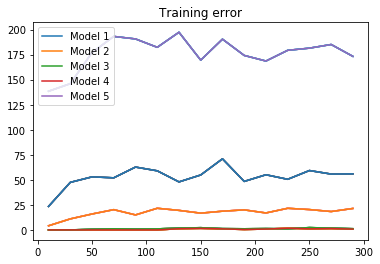

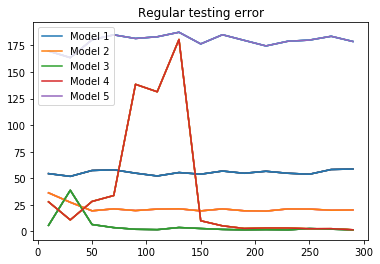

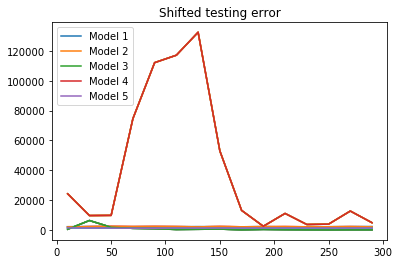

In [36]:
for i in train_err:
    plt.plot(train, train_err_model_1)
    plt.plot(train, train_err_model_2)
    plt.plot(train, train_err_model_3)
    plt.plot(train, train_err_model_4)
    plt.plot(train, train_err_model_5)
plt.legend(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'])
plt.title('Training error')
plt.show()

for i in testr_err:
    plt.plot(train, reg_test_err_model_1)
    plt.plot(train, reg_test_err_model_2)
    plt.plot(train, reg_test_err_model_3)
    plt.plot(train, reg_test_err_model_4)
    plt.plot(train, reg_test_err_model_5)
plt.legend(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'])
plt.title("Regular testing error")
plt.show()

for i in tests_err:
    plt.plot(train, shift_test_err_model_1)
    plt.plot(train, shift_test_err_model_2)
    plt.plot(train, shift_test_err_model_3)
    plt.plot(train, shift_test_err_model_4)
    plt.plot(train, shift_test_err_model_5)
plt.legend(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'])
plt.title("Shifted testing error")
plt.show()

For the training error, as the degree increases in the polynomial, the training error goes down.  This is expected as we have seen previously in the class.  For testing error, increasing the polynomial degree causes large testing error most likely due to overfitting to noise in the data.  However, this problem can be rectified by adding more data. There is something off about my training error plot however, it is unexpected that the neural network would have such a training error, consistently higher than the other models.

Part C:

In [44]:
# vary the number of neurons in the neural network
# define a new model_5 to vary l and k(for part d)
# model 5 is the neural network - taken from previous hws
# 2 hidden layers with 100 neurons and Relu as the nonlinearity 
def model_5_kl(distance, obj_loc,k,l):
    # l = number of neurons per hidden layer
    # k = number of hidden layers
    
    # need to normalize the data
    ave_distance=np.mean(distance,0)
    std_distance=np.std(distance,0)
    distance_norm=(distance-ave_distance)/std_distance
    ave_obj_loc=np.mean(obj_loc,0)
    std_obj_loc=np.std(obj_loc,0)
    obj_loc_norm=(obj_loc-ave_obj_loc)/std_obj_loc
    
    #taken from HW 7
    model = Model(7) # 7 sensors
    # k hidden layers with l nodes
    for i in range(0,k):
        model.addLayer(DenseLayer(l, ReLUActivation()))
    # output 2
    model.addLayer(DenseLayer(2, LinearActivation()))
    model.initialize(QuadraticCost())

    hist = model.train(distance_norm,obj_loc_norm,5000,GDOptimizer(eta=0.0001))
    return model, ave_distance, std_distance, ave_obj_loc, std_obj_loc

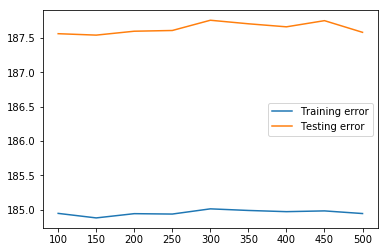

In [48]:
num_neurons = np.arange(100, 501, 50)

distance, obj_loc = generate_dataset(sensor_loc, num_data = 200)
distance_test, obj_loc_test = generate_dataset(sensor_loc, num_data = 1000)

train_err_model_5 = []
test_err_model_5 = []

for l in num_neurons:
    model, ave_distance, std_distance, ave_obj_loc, std_obj_loc = model_5_kl(distance, obj_loc, 2, l)
    train_err_model_5.append(error(obj_loc, model_5_test(distance, model, ave_distance, std_distance, ave_obj_loc, std_obj_loc)))
    test_err_model_5.append(error(obj_loc_test, model_5_test(distance_test, model, ave_distance, std_distance, ave_obj_loc, std_obj_loc)))
    
plt.plot(num_neurons, train_err_model_5)
plt.plot(num_neurons, test_err_model_5)
plt.legend(['Training error', 'Testing error'])
plt.show()

While there's not much variation, from the plot the best choice is 150.

Part D:

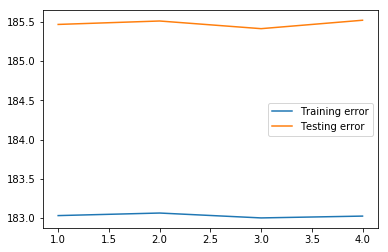

In [51]:
# we want the number of weights to be 10,000
# let l = 100, then we have 10900 weights in total
num_neurons = [1111,96,68,56]
num_layers = [1, 2, 3, 4]

distance, obj_loc = generate_dataset(sensor_loc, num_data = 200)
distance_test, obj_loc_test = generate_dataset(sensor_loc, num_data = 1000)

train_err_model_5 = []
test_err_model_5 = []

for i in range(0,len(num_neurons)):
    l=num_neurons[i]
    k=num_layers[i]
    model, ave_distance, std_distance, ave_obj_loc, std_obj_loc = model_5_kl(distance, obj_loc, 2, l)
    train_err_model_5.append(error(obj_loc, model_5_test(distance, model, ave_distance, std_distance, ave_obj_loc, std_obj_loc)))
    test_err_model_5.append(error(obj_loc_test, model_5_test(distance_test, model, ave_distance, std_distance, ave_obj_loc, std_obj_loc)))
    
plt.plot(num_layers, train_err_model_5)
plt.plot(num_layers, test_err_model_5)
plt.legend(['Training error', 'Testing error'])
plt.show()

Again, there's not much difference so there's probably a bug but I'll choose k=3

Part E:

In [52]:
# Initialize sensor locations, obj locations, and distance
np.random.seed(0)
sensor_loc = generate_sensors()

train_err_model_1=[]
train_err_model_2=[]
train_err_model_3=[]
train_err_model_4=[]
train_err_model_5=[]
reg_test_err_model_1=[]
reg_test_err_model_2=[]
reg_test_err_model_3=[]
reg_test_err_model_4=[]
reg_test_err_model_5=[]
shift_test_err_model_1=[]
shift_test_err_model_2=[]
shift_test_err_model_3=[]
shift_test_err_model_4=[]
shift_test_err_model_5=[]


n_test=1000
# generate the testing sets
reg_distance, reg_obj_loc = generate_dataset(sensor_loc, num_data = n_test)
shift_distance, shift_obj_loc = generate_dataset(sensor_loc, num_data = n_test, original_dist = False)

train = np.arange(10, 291, 20)

for n_train in train:
    # generate the true data
    distance, obj_loc = generate_dataset(sensor_loc, num_data = n_train)

    # calc error for model 1
    estimated_sensor_loc = model_1(sensor_loc, distance, obj_loc)
    train_err_model_1.append(error(obj_loc, model_1_test(distance, estimated_sensor_loc)))
    reg_test_err_model_1.append(error(reg_obj_loc, model_1_test(reg_distance, estimated_sensor_loc)))
    shift_test_err_model_1.append(error(shift_obj_loc, model_1_test(shift_distance, estimated_sensor_loc)))
    
    # calc error for model 2
    A, B = model_2(distance, obj_loc)
    train_err_model_2.append(error(obj_loc, model_2_test(distance, A, B))) 
    reg_test_err_model_2.append(error(reg_obj_loc, model_2_test(reg_distance, A, B)))
    shift_test_err_model_2.append(error(shift_obj_loc, model_2_test(shift_distance, A, B)))
    
    # calc error for model 3
    A, B = model_3(distance, obj_loc)
    train_err_model_3.append(error(obj_loc, model_3_test(distance, A, B))) 
    reg_test_err_model_3.append(error(reg_obj_loc, model_3_test(reg_distance, A, B)))
    shift_test_err_model_3.append(error(shift_obj_loc, model_3_test(shift_distance, A, B)))
    
    # calc error for model 4
    A, B = model_4(distance, obj_loc)
    train_err_model_4.append(error(obj_loc, model_4_test(distance, A, B))) 
    reg_test_err_model_4.append(error(reg_obj_loc, model_4_test(reg_distance, A, B)))
    shift_test_err_model_4.append(error(shift_obj_loc, model_4_test(shift_distance, A, B)))
    
    # calc error for model 5
    k=3
    l=68
    model, ave_distance, std_distance, ave_obj_loc, std_obj_loc = model_5_kl(distance, obj_loc,k,l)
    train_err_model_5.append(error(obj_loc, model_5_test(distance, model, ave_distance, std_distance, ave_obj_loc, std_obj_loc)))
    reg_test_err_model_5.append(error(reg_obj_loc, model_5_test(reg_distance, model, ave_distance, std_distance, ave_obj_loc, std_obj_loc)))
    shift_test_err_model_5.append(error(shift_obj_loc, model_5_test(shift_distance, model, ave_distance, std_distance, ave_obj_loc, std_obj_loc)))

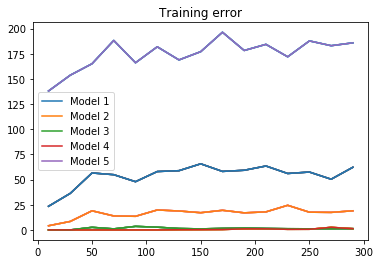

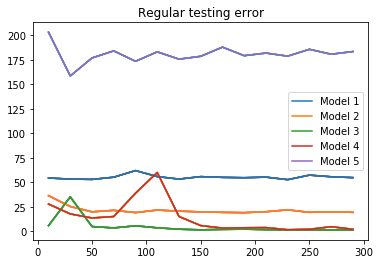

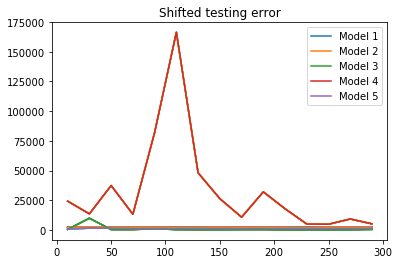

In [53]:
for i in train_err:
    plt.plot(train, train_err_model_1)
    plt.plot(train, train_err_model_2)
    plt.plot(train, train_err_model_3)
    plt.plot(train, train_err_model_4)
    plt.plot(train, train_err_model_5)
plt.legend(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'])
plt.title('Training error')
plt.show()

for i in testr_err:
    plt.plot(train, reg_test_err_model_1)
    plt.plot(train, reg_test_err_model_2)
    plt.plot(train, reg_test_err_model_3)
    plt.plot(train, reg_test_err_model_4)
    plt.plot(train, reg_test_err_model_5)
plt.legend(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'])
plt.title("Regular testing error")
plt.show()

for i in tests_err:
    plt.plot(train, shift_test_err_model_1)
    plt.plot(train, shift_test_err_model_2)
    plt.plot(train, shift_test_err_model_3)
    plt.plot(train, shift_test_err_model_4)
    plt.plot(train, shift_test_err_model_5)
plt.legend(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'])
plt.title("Shifted testing error")
plt.show()